# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

In [40]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')
display(item_features.head(2), user_features.head(2))

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)
display(item_features.head(2), user_features.head(2))

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [15]:
# Берем тестового юзера 2375

In [16]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 1044078, 871756, 844179]

In [17]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [18]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 933067, 999270, 5568447, 1062863]

In [19]:
# recommender.get_similar_users_recommendation(2375, N=5)

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [20]:
ACTUAL_COL = 'actual'

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [22]:
# N = Neighbors
N_PREDICT = 50 

In [23]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

CPU times: user 38.2 s, sys: 23 s, total: 1min 1s
Wall time: 35 s


In [24]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 4.77 µs


### Пример оборачивания

In [25]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [26]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [27]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [28]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [29]:
TOPK_RECALL = 50

In [30]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.047792609498022706),
 ('sim_item_rec', 0.03302066665262913)]

### Precision@5 of matching

In [31]:
TOPK_PRECISION = 5

In [32]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.11808461180846025),
 ('sim_item_rec', 0.053835425383542926)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [33]:
# 3 временных интервала
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [34]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [35]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [36]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [37]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [38]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [39]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


### Check warm start

In [40]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [41]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [42]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [43]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [44]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [45]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [46]:
df_ranker_train['target'].mean()

0.07286953595333358

![hard_choice.png](attachment:hard_choice.png)

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [47]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [48]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [49]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [50]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [51]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [52]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [53]:
# делали на вебинаре, кусок с катбустом

# from catboost import CatBoost, Pool

# df_bin_feat = pd.get_dummies(X_train)

# model = CatBoost(params ={'objective': "Logloss",
#                           "iterations":1000,
#                           "max_depth":8,
#                           "task_type":"GPU",
#                           "devices":"0:1:2:3"
#             })
# model.fit(df_bin_juice, y_train, silent=True)

# train_preds = model.predict(df_bin_feat,prediction_type="Probability")

In [54]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [55]:
df_ranker_predict = df_ranker_train.copy()

In [56]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [57]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.027610
1    0.021650
2    0.039655
3    0.000883
4    0.327586
5    0.038229
6    0.050684
7    0.001076
8    0.097083
9    0.421454
Name: proba_item_purchase, dtype: float64

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [58]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


## Eval matching on test dataset

In [59]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.82 s, sys: 34.8 ms, total: 5.85 s
Wall time: 5.83 s


In [60]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [61]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [62]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [63]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15195822454307964)
('own_rec', 0.1444117647058813)


/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [64]:
def CalcRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=k))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k), axis=1).mean()

In [65]:
k_list = [20, 50, 100, 200, 500]

recall_als_list = []

for k in k_list:
    result_als = CalcRecall(result_eval_matcher, USER_COL, recommender.get_als_recommendations)
    recall_als_list.append(result_als)

In [95]:
best_result_recall_als = pd.DataFrame(recall_als_list, columns={'Recall_ALS'})

In [96]:
best_result_recall_als.sort_values('Recall_ALS', ascending=False)

,Recall_ALS
4,0.146648
3,0.098431
2,0.069848
1,0.047793
0,0.029893


Text(0.5, 1.0, 'Distrubution of eval of recall metrics - ALS')

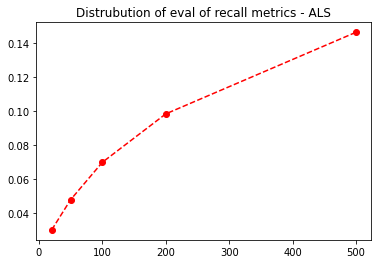

In [97]:
plt.plot(k_list, best_result_recall_als,'go--', color='red', marker='o')
plt.title('Distrubution of eval of recall metrics - ALS')

In [90]:
recall_own_rec_list = []

for k in k_list:
    result_own_rec = CalcRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)
    recall_own_rec_list.append(result_own_rec)

In [103]:
best_result_recall_own_rec = pd.DataFrame(recall_own_rec_list, columns={'Recall_OWN_REC'})
best_result_recall_own_rec.sort_values('Recall_OWN_REC', ascending=False)

,Recall_OWN_REC
4,0.182053
3,0.135373
2,0.096045
1,0.065257
0,0.039284


[]

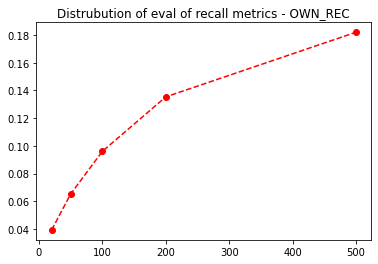

In [107]:
plt.plot(k_list, best_result_recall_own_rec, 'go--', color='red')
plt.title('Distrubution of eval of recall metrics - OWN_REC')
plt.plot()

In [108]:
recall_similar_items_list = []

for k in k_list:
    result_similar_items = CalcRecall(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation)
    recall_similar_items_list.append(result_similar_items)

In [110]:
best_result_recall_similar_items = pd.DataFrame(recall_similar_items_list, columns={'Recall_Similar_items'})
best_result_recall_similar_items.sort_values('Recall_Similar_items',ascending=False)

,Recall_Similar_items
4,0.135392
3,0.084805
2,0.052703
1,0.033021
0,0.017156


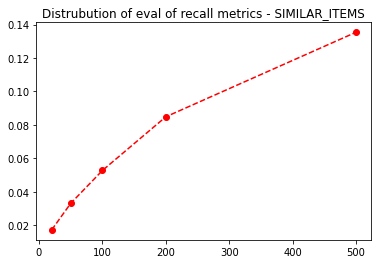

In [116]:
plt.plot(k_list, recall_similar_items_list, 'go--', color='red')
plt.title('Distrubution of eval of recall metrics - SIMILAR_ITEMS')
plt.show()

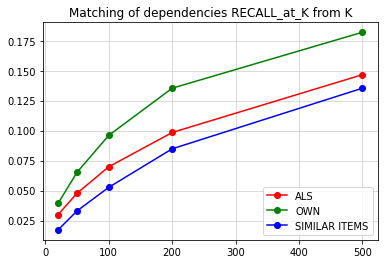

In [118]:
plt.plot(k_list, recall_als_list, 'ro-', label='ALS')
plt.plot(k_list, recall_own_rec_list, 'go-', label='OWN')
plt.plot(k_list, recall_similar_items_list, 'bo-', label='SIMILAR ITEMS')

plt.legend(loc="lower right")
plt.grid(color="lightgrey")
plt.title('Matching of dependencies RECALL_at_K from K')
plt.show()

## Conclusion

А) Дают ли own recommendtions + top-popular лучший recall? -
Да, максимум при K = 500 равен 0.18

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}
С увелечением К увеличивается recall@k, можно предположить что с увелечением К более 500 будет замедяться рост показателя. 

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?
500 тк идет рост.

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [123]:
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [124]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


In [125]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,total_quantity_value,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,109,93,796,3623.85,1.197802,200.978022,0.000589,0.098888,0.000503,0.004304
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,54,51,796,3623.85,0.593407,200.978022,0.000292,0.098888,0.000276,0.004304
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,54,45,796,3623.85,0.593407,200.978022,0.000292,0.098888,0.000243,0.004304
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,49,44,796,3623.85,0.538462,200.978022,0.000265,0.098888,0.000238,0.004304
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,59,53,796,3623.85,0.648352,200.978022,0.000319,0.098888,0.000287,0.004304


In [128]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [129]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [130]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=10,
                     n_estimators=200,
                     learning_rate=0.1,
                     categorical_column=cat_feats,
                     n_jobs=-1)

lgb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CPU times: user 12.6 s, sys: 2.51 ms, total: 12.6 s
Wall time: 7.18 s


In [136]:
train_preds = lgb.predict_proba(X_train)
train_preds.view()

array([[0.97431332, 0.02568668],
       [0.99141168, 0.00858832],
       [0.9932056 , 0.0067944 ],
       ...,
       [0.98644389, 0.01355611],
       [0.94613735, 0.05386265],
       [0.81819465, 0.18180535]])

In [133]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,total_quantity_value,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,109,93,796,3623.85,1.197802,200.978022,0.000589,0.098888,0.000503,0.004304
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,54,51,796,3623.85,0.593407,200.978022,0.000292,0.098888,0.000276,0.004304
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,54,45,796,3623.85,0.593407,200.978022,0.000292,0.098888,0.000243,0.004304
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,49,44,796,3623.85,0.538462,200.978022,0.000265,0.098888,0.000238,0.004304
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,59,53,796,3623.85,0.648352,200.978022,0.000319,0.098888,0.000287,0.004304


In [137]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [138]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [141]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 7.22 s, sys: 58.2 ms, total: 7.28 s
Wall time: 7.83 s


In [142]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

In [143]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [144]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [145]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('reranked_own_rec', 0.1826631853785886)
('own_rec', 0.1444117647058813)


Conclusion

Добавление фичей повлияло позитивно на прирост precision 

In [156]:
print(f'Прирост:, {round((100 - 0.14/0.18 * 100),2)}%')

Прирост:, 22.22%
